# !!This File Was Designed to Run on Google Colab!!

In [1]:
!pip install transformers
!pip install pyspellchecker
!pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 16.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from spellchecker import SpellChecker

from tqdm.notebook import tqdm
from google.colab import drive

# 1 Load Data & Pre-trained Classifier

In [ ]:
#### Load data
drive.mount("/content/gdrive")
# Create the dictionary of brand name as the search key
# {"Fiat": "Dec 31, 2020", "Mini": "Jul 9, 2019", "VW": "Feb 14, 2014", "Pg": "Feb 25, 2019", "Tesla": "Aug 30, 2019"}
dic_brand = {"Fiat": "Dec 31, 2020", "Mini": "Jul 9, 2019", "VW": "Feb 14, 2014", "Pg": "Feb 25, 2019", "Tesla": "Aug 30, 2019"}
df_all = []
l_brand = []
date_launch = []
#### Load data by brand
for key, date in dic_brand.items():
# create paths for post and comment data
    path_comment = "/content/gdrive/My Drive/Data_NLP/" + key + "_topic_dis.csv"
    df_all.append(pd.read_csv(path_comment))
    l_brand.append(key)
    date_launch.append(pd.to_datetime(date,  format="%b %d, %Y"))
print("Launch Date:", date_launch)
df_all[0].info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Launch Date: [Timestamp('2020-12-31 00:00:00'), Timestamp('2019-07-09 00:00:00'), Timestamp('2014-02-14 00:00:00'), Timestamp('2019-02-25 00:00:00'), Timestamp('2019-08-30 00:00:00')]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      730 non-null    int64 
 1   Dominant_Topic  730 non-null    int64 
 2   Date            730 non-null    object
 3   Text            730 non-null    object
dtypes: int64(2), object(2)
memory usage: 22.9+ KB


In [5]:
#### Load Pre-trained Model
# Load model directly
model = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
df_all[0].head(5)

,Unnamed: 0,Dominant_Topic,Date,Text
0,659,0,2021-04-26,"...\n\nDrove the Mini e, BMW i3S (we own the r..."
1,463,0,2022-01-18,"I've posted this before, but it is an illustra..."
2,314,0,2022-05-22,"The Mokka wheels are a big enough pain, there ..."
3,168,0,2023-03-10,"Screenwash...\nI usually use Preston, the yell..."
4,414,0,2022-02-04,I bought this one from Amazon last year which ...


# 2 Text Preprocessing

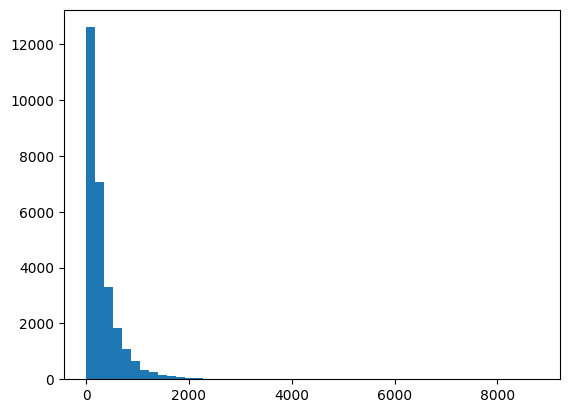

The proportion of long comments to be truncated: 0.17948532861731692


In [23]:
#### Convert Date data type
# The list of dataframes that contain Date and Text
brand_index = 4
df_cmt = df_all[brand_index][['Dominant_Topic', 'Date', 'Text']]
# Convert text data to a list of token docs
docs = df_cmt["Text"].to_list()
docs_512 = [text[:512] if len(text) > 512 else text for text in docs]

#### Check comment lengths' distribution
len_l = []
for i in docs:
  len_l.append(len(i))
plt.hist(len_l, bins=50)
plt.show()
# Check comments that longer than 512
count = sum(1 for length in len_l if length > 512)
print("The proportion of long comments to be truncated:", count/len(docs))

# 3 Classify Texts' Sentiments

In [24]:
#### Predict Results of Model 1
pred = model(docs_512)
pred[:5]
#### Get Labels of Predictions
df_pred = pd.DataFrame(pred)[["label"]]

In [25]:
#### Store sentiment by merging dataframes
df_senti_topic = pd.concat([df_cmt, df_pred], axis=1)
df_senti_topic.to_csv(f"/content/gdrive/My Drive/Data_Vis/{l_brand[brand_index]}_senti_topic.csv", header=True)
df_senti_topic.head(10)

,Dominant_Topic,Date,Text,label
0,0,2018-01-31,...\n\nHere's my theory on what happened and w...,neutral
1,0,2016-07-03,There are some suggestions that the radar syst...,neutral
2,0,2021-04-23,...\n\n\nI think that the assumption that the ...,negative
3,0,2014-10-10,"Jimbo said: ""The functionality is supported by...",neutral
4,0,2016-07-02,My own viewpoint after several thousand miles ...,positive
5,0,2018-04-26,...\n\nI don't believe for a second that AP wa...,neutral
6,0,2018-11-17,I second the comments about relaxation above. ...,neutral
7,0,2018-02-08,...\n\nExcept that's not how autonomous drivin...,neutral
8,0,2019-02-14,"...\n\nSorry, but not according to this: (scro...",neutral
9,0,2016-10-12,"Some good points, especially about computers b...",positive
